# Matching and Subclassification

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import math
import random

# 5.1.3 Subclassification Exercise

In [2]:
# titanic

url = 'https://github.com/scunning1975/mixtape/raw/master/titanic.dta'

df = pd.read_stata(url)

# calculate SDO

df['is_first_class'] = df['class'] == '1st class'
df['survived'] = df.survived == 'yes'

grouped_mean = df.groupby("is_first_class").survived.mean()
SDO = grouped_mean[True] - grouped_mean[False]
print(SDO)

0.3538264720354272


In [3]:
# titanic_subclassification

# stratify into four groups

df['group'] = None

for age in set(df.age):
    is_age = df.age == age
    
    for sex in set(df.sex):
        is_sex = df.sex == sex
        
        df.loc[is_age & is_sex, 'group'] = age + "-" + sex

Text(0, 0.5, 'Age & Sex Group')

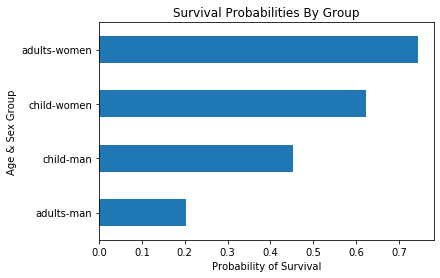

In [4]:
df.groupby("group").survived.mean().sort_values().plot.barh()
plt.title("Survival Probabilities By Group")
plt.xlabel('Probability of Survival')
plt.ylabel("Age & Sex Group")

In [5]:
non_first_class = df[df.is_first_class == False]

weights = non_first_class.groupby('group').survived.count() / len(non_first_class)

# Weighted ATE

wate = 0

for group in weights.index:
    
    temp = df[df.group == group]
    grouped_mean = temp.groupby('is_first_class').survived.mean()
    
    sdo = grouped_mean[True] - grouped_mean[False]
    
    wate += weights[group]*sdo
    
print('Weighted Average Treatment Effect', round(wate,4), sep = ': ')

Weighted Average Treatment Effect: 0.1888


# 5.2 Exact Matching

In [6]:
import warnings
# ignoring warnings related to histograms
warnings.filterwarnings('ignore')

In [7]:
url = "https://raw.github.com/scunning1975/mixtape/master/training_example.dta"

df = pd.read_stata(url)

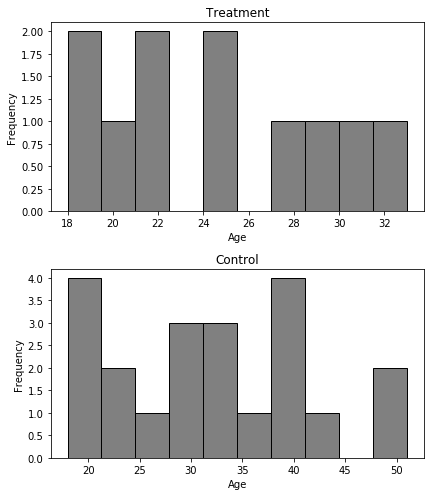

In [8]:
fig, ax = plt.subplots(2,1, figsize = (6,7))

ax[0].hist(df.age_treat, bins = 10, edgecolor = 'black', facecolor = 'gray')
ax[0].set_title("Treatment")

ax[1].hist(df.age_control, bins = 10, edgecolor = 'black', facecolor = 'gray')
ax[1].set_title("Control")

for item in ax:
    item.set_xlabel('Age')
    item.set_ylabel("Frequency")

fig.tight_layout()

In [9]:
# compare means

In [10]:
df.loc[0:9,['age_treat', 'earnings_treat']].astype(float).mean() # type changed to avoid sci notation

age_treat            24.3
earnings_treat    11075.0
dtype: float64

In [11]:
df.loc[0:9,['age_matched', 'earnings_matched']].mean()

age_matched           24.3
earnings_matched    9380.0
dtype: float64

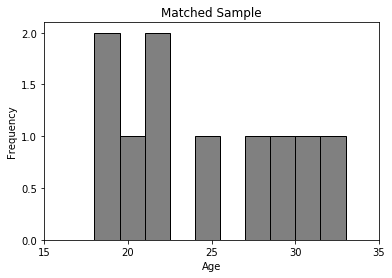

In [12]:
# Groups are exactly balanced on age
# Figure 5.2 

fig, ax = plt.figure(), plt.axes()
ax.hist(df.age_matched, bins = 10, edgecolor = 'black', facecolor = 'gray')
ax.set_title("Matched Sample")
ax.set_xlabel("Age")
ax.set_ylabel("Frequency")
ax.set_xlim([15,35])
ax.set_xticks(range(15,36,5))
ax.set_yticks(np.linspace(0,2, 5))
plt.show()

# 5.3 Approximate Matching

## 5.3.2 Bias Correction

In [13]:
# training_bias_reduction

url =  'https://github.com/scunning1975/mixtape/raw/master/training_bias_reduction.dta'
df = pd.read_stata(url)

In [14]:
df['Y0'] = [4,0,5,1]*2
df['Y1'] = [5, 2, 10, 6] + [None]*4

df

,Unit,Y,D,X,Y0,Y1
0,1,5,1,11,4,5.0
1,2,2,1,7,0,2.0
2,3,10,1,5,5,10.0
3,4,6,1,3,1,6.0
4,5,4,0,10,4,NaN
5,6,0,0,8,0,NaN
6,7,5,0,4,5,NaN
7,8,1,0,1,1,NaN


In [15]:
unadjusted_treatment_effect = (df.Y1 - df.Y0).mean()

In [16]:
unadjusted_treatment_effect

3.25

In [17]:
## OLS 

In [18]:
import statsmodels.api as sm

In [19]:
df['const'] = 1
model = sm.OLS(df.Y, df[['X','const']])


In [20]:
fitted = model.fit()

#print(fitted.summary())

In [21]:
mu_hat = df[['X','const']].apply(lambda x: np.dot(x,fitted.params), axis = 1)

In [22]:
df['mu_hat'] = mu_hat

In [23]:
# bias corrected att

df['nearest_mu_hat'] = df.mu_hat.shift(-4)

In [24]:
adjusted_att = ((df.Y1 - df.Y0) - (df.mu_hat - df.nearest_mu_hat)).mean()

In [25]:
adjusted_att

3.2864506627393224

## 5.3.4 Propensity Score Methods

In [39]:
# nsw_experimental

url = 'https://github.com/scunning1975/mixtape/raw/master/nsw_mixtape.dta'
df = pd.read_stata(url)

In [40]:
grouped_means = df.groupby('treat').re78.mean()
ate = grouped_means[1] - grouped_means[0]

print('ATE:', ate)

ATE: 1794.3423


#### Pscores

In [41]:
# nsw_pscore

cps_url = 'https://github.com/scunning1975/mixtape/raw/master/cps_mixtape.dta'
cps_df = pd.read_stata(cps_url)

In [42]:
# combine datasets
combined = cps_df.append(df)

combined['u74'], combined['u75'] = 1 * (combined.re74 == 0), 1 * (combined.re75 == 0)

In [43]:
# fit logit 
combined['age_sq'] = combined.age ** 2
combined['age_cube'] = combined.age ** 3
combined['educ_sq'] = combined.educ ** 2
combined['educ_re74'] = combined.educ * combined.re74
combined['const'] = 1

X_vars = ['age', 'age_sq', 'age_cube', 'educ', 'educ_sq', 'marr', 'nodegree',
             'black', 'hisp', 're74', 're75', 'u74', 'u75', 'educ_re74', 'const']

logit_model = sm.Logit(combined.treat, combined[X_vars], )
fitted = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.032425
         Iterations 12


In [44]:
from scipy.special import expit

# full form
# combined['logit_pscore'] = combined[X_vars].apply(lambda x: expit(np.dot(x,fitted.params)), axis = 1)

combined['logit_pscore'] = fitted.predict(combined[X_vars])

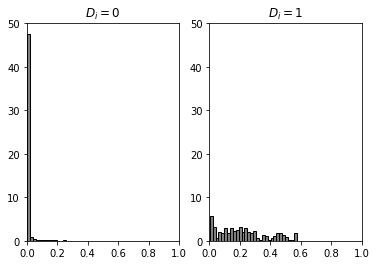

In [45]:
fig, ax = plt.subplots(1,2)

#from math import log
#k = int(min(np.sqrt(len(combined)), 10* log(len(combined))/log(10)))

ax[0].hist(combined[combined.treat == 0].logit_pscore, 
                bins = 30, facecolor = 'gray', edgecolor = 'black', density = True)
ax[1].hist(combined[combined.treat == 1].logit_pscore, 
                bins = 30, facecolor = 'gray', edgecolor = 'black', density = True)
    
for key in 0,1:
    ax[key].set_ylim((0,50))
    ax[key].set_xlim((0,1))
    ax[key].set_title(r"$D_i = " + str(key) + r"$")


In [46]:
print(fitted.summary())

                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                16437
Model:                          Logit   Df Residuals:                    16422
Method:                           MLE   Df Model:                           14
Date:                Tue, 11 May 2021   Pseudo R-squ.:                  0.4744
Time:                        14:40:52   Log-Likelihood:                -532.97
converged:                       True   LL-Null:                       -1014.0
Covariance Type:            nonrobust   LLR p-value:                2.073e-196
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age            1.2369      0.307      4.027      0.000       0.635       1.839
age_sq        -0.0335      0.010     -3.382      0.001      -0.053      -0.014
age_cube       0.0003      0.000      2.703      0.0

# 5.3.5 Weighting on the propensity score

In [47]:
# ipw

combined.head()

,data_id,treat,age,educ,black,hisp,marr,nodegree,re74,re75,re78,u74,u75,age_sq,age_cube,educ_sq,educ_re74,const,logit_pscore
0,CPS1,0.0,45.0,11.0,0.0,0.0,1.0,1.0,21516.669922,25243.550781,25564.669922,0,0,2025.0,91125.0,121.0,236683.375000,1,0.000020
1,CPS1,0.0,21.0,14.0,0.0,0.0,0.0,0.0,3175.970947,5852.564941,13496.080078,0,0,441.0,9261.0,196.0,44463.593750,1,0.001190
2,CPS1,0.0,38.0,12.0,0.0,0.0,1.0,0.0,23039.019531,25130.759766,25564.669922,0,0,1444.0,54872.0,144.0,276468.250000,1,0.000042
3,CPS1,0.0,48.0,6.0,0.0,0.0,1.0,1.0,24994.369141,25243.550781,25564.669922,0,0,2304.0,110592.0,36.0,149966.218750,1,0.000007
4,CPS1,0.0,18.0,8.0,0.0,0.0,1.0,1.0,1669.295044,10727.610352,9860.869141,0,0,324.0,5832.0,64.0,13354.360352,1,0.000392


In [48]:
N = len(combined)

# manual with non-normalized weights using all data

combined['d1'] = combined.treat / combined.logit_pscore
combined['d0'] = (1-combined.treat) / (1-combined.logit_pscore)

In [49]:
s1, s0 = combined.d1.sum(), combined.d0.sum()

In [51]:
combined['y1'] = combined.treat * combined.re78 / combined.logit_pscore
combined['y0'] = (1-combined.treat) * combined.re78 / (1-combined.logit_pscore)
combined['ht'] = combined.y1 - combined.y0

In [53]:
te_1 = combined.ht.mean()
print("Treatment effect (non-normalized)", round(te_1, 4))

Treatment effect (non-normalized) -12504.9038
